### Load cleaned dataset and previous libraries & data frames

[*********************100%***********************]  4 of 4 downloaded
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2008-10-01 to 2019-09-30
Data columns (total 24 columns):
(Adj Close, AAPL)    2768 non-null float64
(Adj Close, AMZN)    2768 non-null float64
(Adj Close, FB)      1853 non-null float64
(Adj Close, MSFT)    2768 non-null float64
(Close, AAPL)        2768 non-null float64
(Close, AMZN)        2768 non-null float64
(Close, FB)          1853 non-null float64
(Close, MSFT)        2768 non-null float64
(High, AAPL)         2768 non-null float64
(High, AMZN)         2768 non-null float64
(High, FB)           1853 non-null float64
(High, MSFT)         2768 non-null float64
(Low, AAPL)          2768 non-null float64
(Low, AMZN)          2768 non-null float64
(Low, FB)            1853 non-null float64
(Low, MSFT)          2768 non-null float64
(Open, AAPL)         2768 non-null float64
(Open, AMZN)         2768 non-null float64
(Open, FB)           1853 non-n

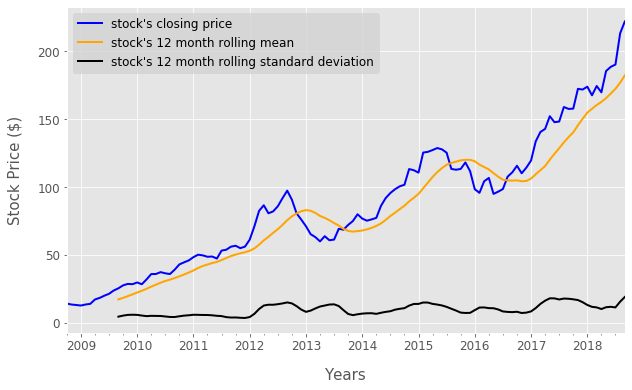

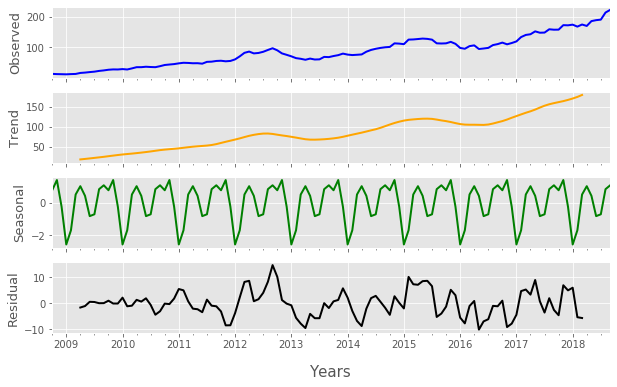

Results of Dickey-Fuller Test:
Test Statistic                   1.685822
p-value                          0.998094
#Lags Used                       0.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


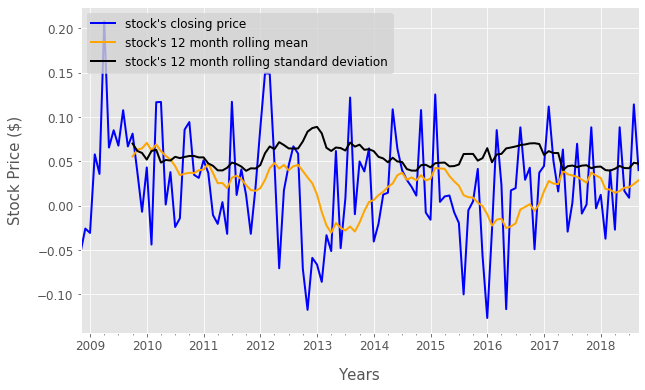

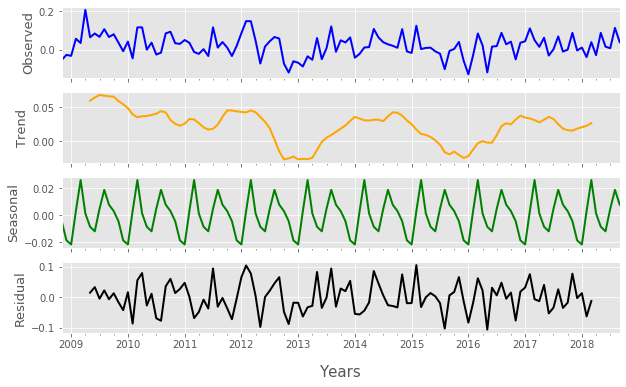

Results of Dickey-Fuller Test:
Test Statistic                -8.235947e+00
p-value                        5.889858e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


In [7]:
%run '/Users/sergiogutierrez/Springboard_projects/Capstone 2/Python-  Time Series Data Cleaning, Wrangling and Stationary Testing.ipynb'

### Load time series libraries

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet

### Plot ACF and PACF on original time series to verify non-stationarity
- **ACF (auto-correlation function)** illustrates the correlation between two different time series: the original time series and its lagged version of one or more of the given time periods.
    - This determines the lagged correlation of a time series, where it will either have positive (+1.0), negative (-1.0), or non-linear relationship (0) with its lagged version of it self.
    
    
- **PACF (partial auto-correlation function)** illustrates the correlation between oberservations at two time spots assuming we consider both observations to be correlated to observations at other time spots.
    - This deterimes the conditional correlation of a time series, where it either have a positive, negative or non-linear relationship with prior periods of itself.

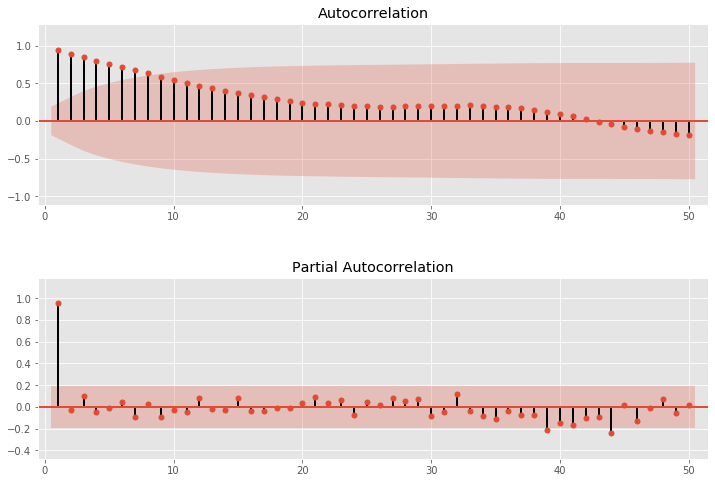

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(hspace=0.4)

plot_acf(stock_train.close.iloc[13:], lags=50, zero=False, ax=ax1)
plot_pacf(stock_train.close.iloc[13:], lags=50, zero=False, ax=ax2)

ax1.margins(x=0.02, y=0.2)
ax2.margins(x=0.02, y=0.2)

plt.show()

### Plot ACF and PACF on transformed time series to confirm stationarity and determine AR and MA lag selections

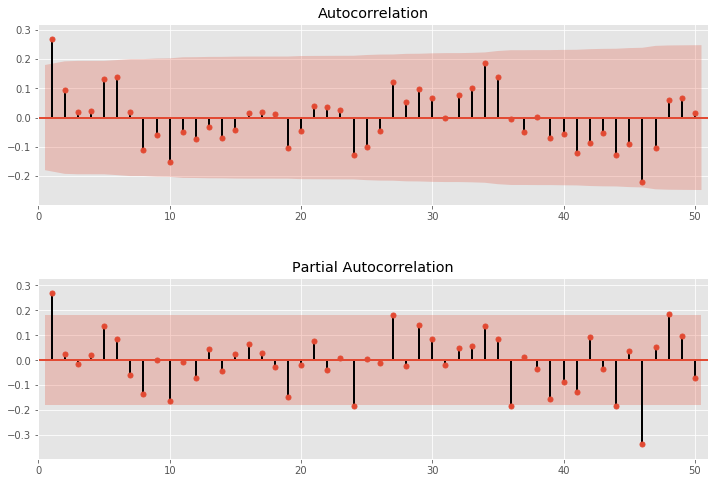

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
fig.subplots_adjust(hspace=0.4)

plot_acf(stock_diff, lags=50, zero=False, ax=ax1)
plot_pacf(stock_diff, lags=50, zero=False, ax=ax2)

ax1.margins(x=0.01, y=0.1)
ax2.margins(x=0.01, y=0.1)

plt.show()

### Build ARMA model with AR(1) and MA(1) based on ACF and PACF results

In [5]:
arima_model = ARIMA(stock_log,
                    freq="M",
                    order=(1,1,1))

arima_results = arima_model.fit()

print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 171.681
Method:                       css-mle   S.D. of innovations              0.057
Date:                Mon, 21 Oct 2019   AIC                           -335.361
Time:                        11:45:43   BIC                           -324.245
Sample:                    11-30-2008   HQIC                          -330.847
                         - 09-30-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0230      0.007      3.123      0.002       0.009       0.037
ar.L1.D.close     0.3539      0.315      1.122      0.264      -0.264       0.972
ma.L1.D.close    -0.0902      0.335     

### Plot and compare the train time series and the ARMA-model time series

<Figure size 864x576 with 0 Axes>

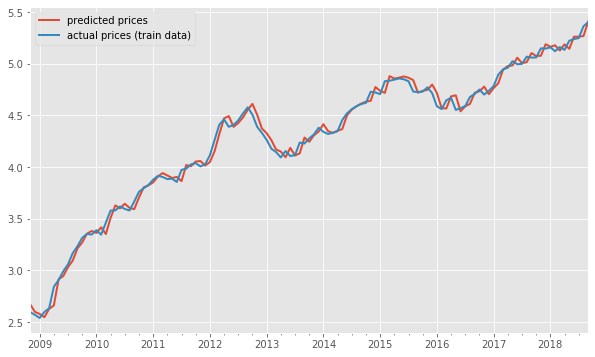

In [8]:
fig = plt.figure(figsize=(12,8))

arima_results.plot_predict(start=1, end=119, plot_insample=True)

plt.legend(loc="upper left", labels=["predicted prices", "actual prices (train data)"])

plt.show()

### Plot and compare the test time series and the ARMA-forecast time series

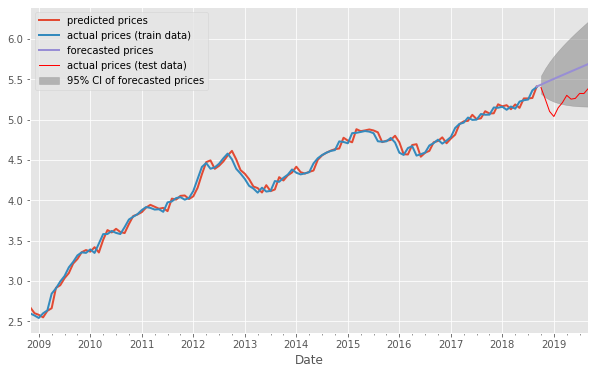

In [9]:
fig, ax = plt.subplots()

arima_results.plot_predict(start=1, end=119, plot_insample=True, ax=ax)
arima_results.plot_predict(start=119, end=131, plot_insample=False, ax=ax)
np.log(stock_test.close).plot(color="red", linewidth=1)

plt.legend(loc="upper left", labels=["predicted prices", "actual prices (train data)", "forecasted prices", "actual prices (test data)", "95% CI of forecasted prices"])

plt.show()

### Test which AR and MA values will provide the best fitting model
- This is determined by AIC value, where the lower value the better fit the model.

In [10]:
sarimax_test = auto_arima(stock_log, 
                          start_p=0, max_p=8, d=1, start_q=0, max_q=8,
                          start_P=0, max_P=8, D=0, start_Q=0, max_Q=8,
                          m=12,n_fits=30, seasonal=True, trend="n",
                          trace=True, suppress_warnings=True, 
                          error_action='warn', random_state=42)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-315.509, BIC=-312.730, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-328.726, BIC=-320.389, Fit time=0.087 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-325.111, BIC=-316.774, Fit time=0.104 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-330.702, BIC=-325.144, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=-328.733, BIC=-320.396, Fit time=0.151 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=-326.957, BIC=-315.841, Fit time=0.241 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-329.755, BIC=-321.417, Fit time=0.035 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=-330.702, BIC=-322.365, Fit time=0.089 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=-331.973, BIC=-318.077, Fit time=0.228 seconds
Fit ARIMA: order=(2, 1, 2) s

In [11]:
sarimax_model = SARIMAX(stock_log,
                        freq="M",
                        trend="n",
                        order=(2,1,2),
                        seasonal_order=(0,0,0,12),
                        simple_differenincing=True,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit()

print(sarimax_results.summary())

                           Statespace Model Results                           
Dep. Variable:                  close   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 167.090
Date:                Mon, 21 Oct 2019   AIC                           -324.180
Time:                        11:47:45   BIC                           -310.412
Sample:                    10-31-2008   HQIC                          -318.591
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4146      0.239      5.929      0.000       0.947       1.882
ar.L2         -0.4286      0.235     -1.826      0.068      -0.889       0.032
ma.L1         -1.2113     26.645     -0.045      0.9

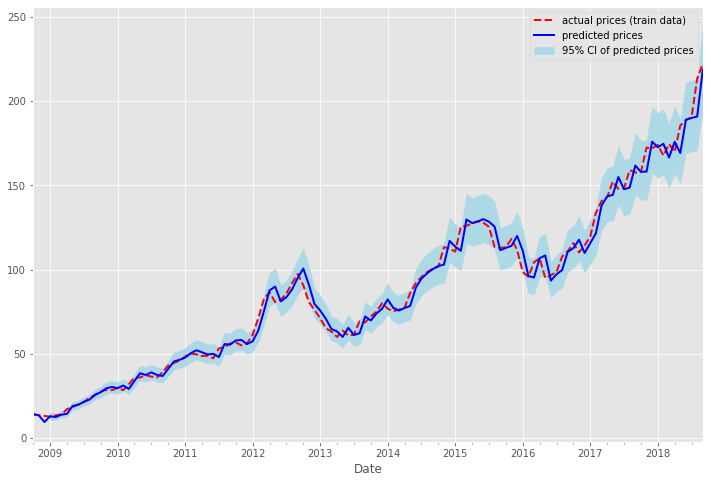

In [12]:
fig = plt.figure(figsize=(12,8))

sarimax_prediction = sarimax_results.get_prediction(start=-120).predicted_mean
sarimax_prediction[0] = stock_log[0]
sarimax_prediction[1] = stock_log[1]
sarimax_prediction = np.exp(sarimax_prediction)

stock_train.close.plot(color="red", linestyle="--", label="actual prices (train data)")
sarimax_prediction.plot(color="blue", label="predicted prices")

prediction_conf_int = sarimax_results.get_prediction(start=-120).conf_int()
prediction_conf_int = prediction_conf_int[2:]
prediction_conf_int = np.exp(prediction_conf_int)
prediction_lower_lim = prediction_conf_int.loc[:,'lower close']
prediction_upper_lim = prediction_conf_int.loc[:,'upper close']

plt.fill_between(prediction_lower_lim.index, 
                 prediction_lower_lim, 
                 prediction_upper_lim, 
                 color="lightblue", 
                 label="95% CI of predicted prices")

plt.legend()

plt.show()

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#print('MAE:{}'.format(mean_absolute_error(stock_train.close, sarimax_prediction)))
#print('MAPE:{}'.format(mean_absolute_percentage_error(stock_train.close, sarimax_prediction)))
#print('MSE:{}'.format(mean_squared_error(stock_train.close, sarimax_prediction)))
print('ARMA predicted model RMSE:{}'.format(np.sqrt(mean_squared_error(stock_train.close, sarimax_prediction))))

ARMA predicted model RMSE:5.496524452109635


### Ensure residuals from the model are both uncorrelated and normally distributed with zero-mean

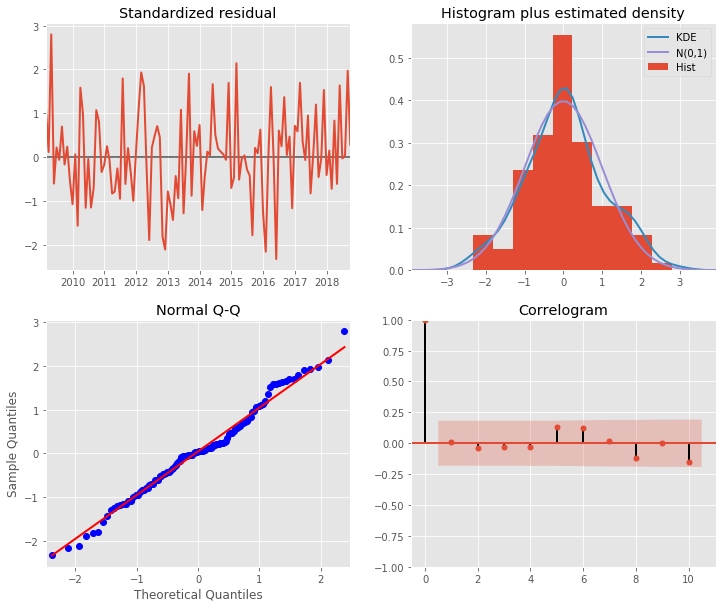

In [14]:
sarimax_results.plot_diagnostics(figsize=(12,10))

plt.show()

### Proceed forward with generating a forecast

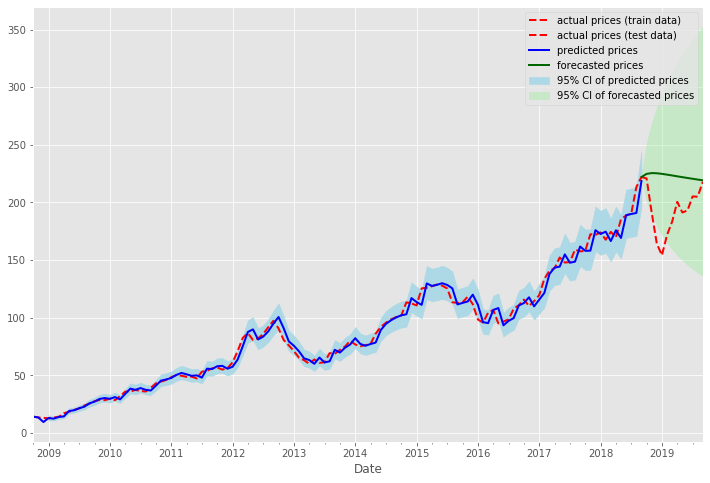

In [15]:
fig = plt.figure(figsize=(12,8))

sarimax_forecast = sarimax_results.get_forecast(steps=12).predicted_mean
sarimax_forecast = np.exp(sarimax_forecast)
sarimax_forecast = sarimax_forecast.append(pd.Series(stock_train.close[-1], index=pd.DatetimeIndex(["2018-09-30"]))).sort_index()

stock_train.close.plot(color="red", linestyle="--", label="actual prices (train data)")
stock_test.close.append(pd.Series(stock_train.close[-1], index=pd.DatetimeIndex(["2018-09-30"]))).sort_index().plot(color="red", linestyle="--", label="actual prices (test data)")

sarimax_prediction.plot(color="blue", label="predicted prices")
sarimax_forecast.plot(color="darkgreen", label="forecasted prices")

forecast_conf_int = sarimax_results.get_forecast(steps=12).conf_int()
forecast_conf_int = np.exp(forecast_conf_int)
forecast_lower_lim = forecast_conf_int.loc[:,'lower close'].append(pd.Series(stock_train.close[-1], index=pd.DatetimeIndex(["2018-09-30"]))).sort_index()
forecast_upper_lim = forecast_conf_int.loc[:,'upper close'].append(pd.Series(stock_train.close[-1], index=pd.DatetimeIndex(["2018-09-30"]))).sort_index()

plt.fill_between(prediction_lower_lim.index, 
                 prediction_lower_lim, 
                 prediction_upper_lim, 
                 color="lightblue", 
                 label="95% CI of predicted prices")
plt.fill_between(forecast_lower_lim.index, 
                 forecast_lower_lim, 
                 forecast_upper_lim, 
                 color="lightgreen", 
                 alpha=0.35, 
                 label="95% CI of forecasted prices")

plt.legend(loc="upper right")

plt.show()

### Calculate error of the forecast from actuals (test data)

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#print('MAE:{}'.format(mean_absolute_error(stock_test.close, sarimax_forecast.iloc[1:])))
#print('MAPE:{}'.format(mean_absolute_percentage_error(stock_test.close, sarimax_forecast.iloc[1:])))
#print('MSE:{}'.format(mean_squared_error(stock_test.close, sarimax_forecast.iloc[1:])))
print('ARMA forecasted model RMSE:{}'.format(np.sqrt(mean_squared_error(stock_test.close, sarimax_forecast.iloc[1:]))))

ARMA forecasted model RMSE:37.58327500668348


### Now use the FB Prophet model to build model and forecast the time series

In [17]:
stock_train_copy = stock_train.reset_index()
stock_train_copy = stock_train_copy[["Date", "close"]]
stock_train_copy = stock_train_copy.rename(columns={"Date": "ds", "close":"y"})

stock_train_copy.head()

,ds,y
0,2008-10-31,14.143913
1,2008-11-30,13.420526
2,2008-12-31,13.078182
3,2009-01-31,12.682000
4,2009-02-28,13.438421


In [18]:
prophet_model = Prophet(growth="linear",
                        seasonality_mode="additive",
                        daily_seasonality=False,
                        weekly_seasonality=False,
                        yearly_seasonality=True)

prophet_model.fit(stock_train_copy)

future_prices = prophet_model.make_future_dataframe(freq="M", periods=12)

prophet_forecast = prophet_model.predict(future_prices)

prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2019-05-31,206.003874,189.687385,221.086795
128,2019-06-30,207.738714,192.831465,223.256691
129,2019-07-31,210.734590,196.163918,226.235097
130,2019-08-31,214.650643,198.468699,229.713470
131,2019-09-30,218.179179,201.609380,233.766100


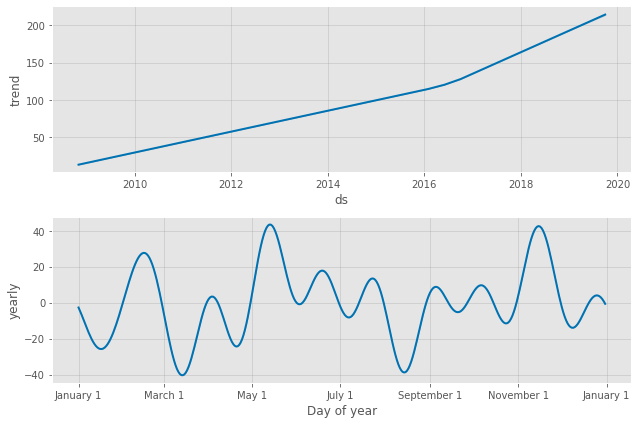

In [19]:
prophet_model.plot_components(prophet_forecast)

plt.show()

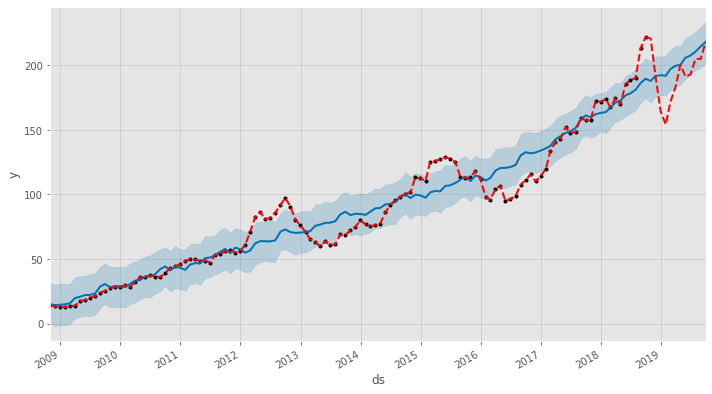

In [20]:
prophet_model.plot(prophet_forecast)

stock_train_copy.set_index("ds").y.plot(color="red", linestyle="--")
stock_test.close.append(pd.Series(stock_train.close[-1], index=pd.DatetimeIndex(["2018-09-30"]))).sort_index().plot(color="red", linestyle="--")

plt.show()

In [21]:
print('Predicted prophet model RMSE:{}'.format(np.sqrt(mean_squared_error(stock_train.close, prophet_forecast.yhat.iloc[0:120]))))
print('Forecasted prophet rophet model RMSE:{}'.format(np.sqrt(mean_squared_error(stock_test.close, prophet_forecast.yhat.iloc[120:]))))

Predicted prophet model RMSE:12.198281339708371
Forecasted prophet rophet model RMSE:19.97211275903643
